In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import nibabel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from skimage.filters import unsharp_mask
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from skimage.transform import resize
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
from dipy.align.imaffine import AffineMap
from dipy.align import resample
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten
from tensorflow.keras.layers import Conv3D, AveragePooling3D, MaxPooling3D
from tensorflow.keras.layers import add, multiply, GlobalAveragePooling3D, GlobalMaxPooling3D, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import concatenate

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals
import six
from math import ceil

In [8]:
def _bn_relu(input):
    """Helper to build a BN -> relu block (by @raghakot)."""
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)

def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        conv = Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(input)
        return _bn_relu(conv)

    return f

In [9]:
def _bn_relu_conv3d(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(activation)

    return f

def _shortcut3d(input, residual):
    stride_dim1 = ceil(input.shape[DIM1_AXIS] / residual.shape[DIM1_AXIS])
    stride_dim2 = ceil(input.shape[DIM2_AXIS] / residual.shape[DIM2_AXIS])
    stride_dim3 = ceil(input.shape[DIM3_AXIS] / residual.shape[DIM3_AXIS])
    equal_channels = residual.shape[CHANNEL_AXIS] == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal",
            padding="valid",
            kernel_regularizer=l2(1e-4),
        )(input)
    return add([shortcut, residual])

In [10]:
def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        conv = Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(input)
        return _bn_relu(conv)

    return f

def _bn_relu_conv3d(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(activation)

    return f

In [11]:
def _shortcut3d(input, residual):
    stride_dim1 = ceil(input.shape[DIM1_AXIS] / residual.shape[DIM1_AXIS])
    stride_dim2 = ceil(input.shape[DIM2_AXIS] / residual.shape[DIM2_AXIS])
    stride_dim3 = ceil(input.shape[DIM3_AXIS] / residual.shape[DIM3_AXIS])
    equal_channels = residual.shape[CHANNEL_AXIS] == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal",
            padding="valid",
            kernel_regularizer=l2(1e-4),
        )(input)
    return add([shortcut, residual])

def _residual_block_with_cbam(
    filters,
    kernel_regularizer,
    is_first_layer=False,
    visualize=False,
):
    def f(input_tensor):
        # First convolutional layer
        strides = (1, 1, 1) if not is_first_layer else (2, 2, 2)
        conv1 = _conv_bn_relu3D(
            filters=filters,
            kernel_size=(3, 3, 3),
            strides=strides,
            kernel_regularizer=kernel_regularizer,
        )(input_tensor)
        
        # Second convolutional layer
        conv2 = _conv_bn_relu3D(
            filters=filters,
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer,
        )(conv1)
        
        # Channel Attention
        channel_avg_pool = GlobalAveragePooling3D()(conv2)
        channel_max_pool = GlobalMaxPooling3D()(conv2)
        channel_dense_avg = Dense(filters // 2, activation="relu")(channel_avg_pool)
        channel_dense_max = Dense(filters // 2, activation="relu")(channel_max_pool)
        channel_attention = Activation("sigmoid")(
            Dense(filters, activation="relu")(add([channel_dense_avg, channel_dense_max]))
        )
        channel_attention = Reshape((1, 1, 1, filters))(channel_attention)
        channel_attention_applied = multiply([conv2, channel_attention])
        
        # Spatial Attention
        spatial_avg_pool = tf.reduce_mean(channel_attention_applied, axis=-1, keepdims=True)
        spatial_max_pool = tf.reduce_max(channel_attention_applied, axis=-1, keepdims=True)
        spatial_attention_input = concatenate([spatial_avg_pool, spatial_max_pool], axis=-1)
        spatial_attention = Conv3D(
            filters=1,
            kernel_size=(7, 7, 7),
            activation="sigmoid",
            padding="same",
            kernel_initializer="he_normal",
        )(spatial_attention_input)
        spatial_attention_applied = multiply([channel_attention_applied, spatial_attention])
        
        # Add shortcut (residual connection)
        if is_first_layer or input_tensor.shape[-1] != filters:
            shortcut = Conv3D(filters, (1, 1, 1), strides=strides, padding='same', kernel_regularizer=kernel_regularizer)(input_tensor)
            shortcut = BatchNormalization()(shortcut)
        else:
            shortcut = input_tensor
        
        output_tensor = add([shortcut, spatial_attention_applied])
        output_tensor = Activation('relu')(output_tensor)
        
        if visualize:
            # Return both the block output and the attention maps
            return output_tensor, channel_attention, spatial_attention
        return output_tensor
    return f

In [12]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, Activation, MaxPooling3D, AveragePooling3D, Dense, Flatten, GlobalAveragePooling3D, GlobalMaxPooling3D, Reshape, multiply, add, concatenate
# from tensorflow.keras.models import Model
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras import backend as K
# import six

def basic_block(
    filters,
    strides=(1, 1, 1),
    kernel_regularizer=l2(1e-4),
    is_first_block_of_first_layer=False,
):
    def f(input):
        if is_first_block_of_first_layer:
            conv1 = Conv3D(
                filters=filters,
                kernel_size=(5, 5, 5),  # Changed kernel size
                strides=strides,
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer,
            )(input)
        else:
            conv1 = _bn_relu_conv3d(
                filters=filters,
                kernel_size=(5, 5, 5),  # Changed kernel size
                strides=strides,
                kernel_regularizer=kernel_regularizer,
            )(input)
        residual = _bn_relu_conv3d(
            filters=filters,
            kernel_size=(5, 5, 5),  # Changed kernel size
            kernel_regularizer=kernel_regularizer,
        )(conv1)
        return _shortcut3d(input, residual)
    return f

def _bn_relu_conv3d(filters, kernel_size, strides=(1, 1, 1), kernel_regularizer=l2(1e-4)):
    def f(input):
        activation = _bn_relu(input)
        return Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding="same",
                      kernel_initializer="he_normal",
                      kernel_regularizer=kernel_regularizer)(activation)
    return f

def _bn_relu(x):
    x = BatchNormalization()(x)
    return Activation("relu")(x)

def _shortcut3d(input, residual):
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_dim1 = input_shape[DIM1_AXIS] // residual_shape[DIM1_AXIS]
    stride_dim2 = input_shape[DIM2_AXIS] // residual_shape[DIM2_AXIS]
    stride_dim3 = input_shape[DIM3_AXIS] // residual_shape[DIM3_AXIS]
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 or not equal_channels:
        shortcut = Conv3D(
            filters=residual_shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            padding="valid",
            kernel_initializer="he_normal",
            kernel_regularizer=l2(1e-4),
        )(input)
    return add([shortcut, residual])

def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == "channels_last":
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4

def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError("Invalid {}".format(identifier))
        return res
    return identifier

def _residual_block_with_cbam(
    filters,
    kernel_regularizer,
    is_first_layer=False,
    visualize=False,
):
    def f(input_tensor):
        strides = (1, 1, 1) if not is_first_layer else (2, 2, 2)
        conv1 = _conv_bn_relu3D(
            filters=filters,
            kernel_size=(3, 3, 3),
            strides=strides,
            kernel_regularizer=kernel_regularizer,
        )(input_tensor)
        
        conv2 = _conv_bn_relu3D(
            filters=filters,
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer,
        )(conv1)
        
        # Channel Attention
        channel_avg_pool = GlobalAveragePooling3D()(conv2)
        channel_max_pool = GlobalMaxPooling3D()(conv2)
        channel_dense_avg = Dense(filters // 2, activation="relu")(channel_avg_pool)
        channel_dense_max = Dense(filters // 2, activation="relu")(channel_max_pool)
        channel_attention = Activation("sigmoid")(
            Dense(filters, activation="relu")(add([channel_dense_avg, channel_dense_max]))
        )
        channel_attention = Reshape((1, 1, 1, filters))(channel_attention)
        channel_attention_applied = multiply([conv2, channel_attention])
        
        # Spatial Attention
        spatial_avg_pool = tf.reduce_mean(channel_attention_applied, axis=-1, keepdims=True)
        spatial_max_pool = tf.reduce_max(channel_attention_applied, axis=-1, keepdims=True)
        spatial_attention_input = concatenate([spatial_avg_pool, spatial_max_pool], axis=-1)
        spatial_attention = Conv3D(
            filters=1,
            kernel_size=(7, 7, 7),
            activation="sigmoid",
            padding="same",
            kernel_initializer="he_normal",
        )(spatial_attention_input)
        spatial_attention_applied = multiply([channel_attention_applied, spatial_attention])
        
        # Add shortcut (residual connection)
        if is_first_layer or input_tensor.shape[-1] != filters:
            shortcut = Conv3D(filters, (1, 1, 1), strides=strides, padding='same', kernel_regularizer=kernel_regularizer)(input_tensor)
            shortcut = BatchNormalization()(shortcut)
        else:
            shortcut = input_tensor
        
        output_tensor = add([shortcut, spatial_attention_applied])
        output_tensor = Activation('relu')(output_tensor)
        
        if visualize:
            return output_tensor, channel_attention, spatial_attention
        return output_tensor
    return f

def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))
    padding = conv_params.setdefault("padding", "same")

    def f(input):
        conv = Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer="he_normal",
            kernel_regularizer=kernel_regularizer,
        )(input)
        return _bn_relu(conv)

    return f

class Resnet3DBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError(
                "Input shape should be a tuple "
                "(conv_dim1, conv_dim2, conv_dim3, channels) "
                "for tensorflow as backend or "
                "(channels, conv_dim1, conv_dim2, conv_dim3) "
                "for theano as backend"
            )
        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        
        # first conv
        conv1 = _conv_bn_relu3D(
            filters=128,  # Changed filter size
            kernel_size=(5, 5, 5),  # Changed kernel size
            strides=(2, 2, 2),
            kernel_regularizer=l2(reg_factor),
        )(input)
        pool1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2), padding="same")(conv1)
        
        # repeat blocks
        attention_maps = []  # Collect attention maps
        block = pool1
        filters = 128  # Changed filter size
        for i, r in enumerate(repetitions):
            for _ in range(r):
                if i == len(repetitions) - 1 and _ == r - 1:  # For the last block
                    block, channel_attention, spatial_attention = _residual_block_with_cbam(
                        filters=filters,
                        kernel_regularizer=l2(reg_factor),
                        is_first_layer=(_ == 0),
                        visualize=True,
                    )(block)
                    attention_maps = [channel_attention, spatial_attention]
                else:
                    block = _residual_block_with_cbam(
                        filters=filters,
                        kernel_regularizer=l2(reg_factor),
                        is_first_layer=(_ == 0),
                    )(block)
            filters *= 2
        
        # last activation
        block_output = _bn_relu(block)
        
        # average pool and classification
        pool2 = AveragePooling3D(
            pool_size=(
                block_output.shape[DIM1_AXIS],
                block_output.shape[DIM2_AXIS],
                block_output.shape[DIM3_AXIS],
            ),
            strides=(1, 1, 1),
        )(block_output)
        flatten1 = Flatten()(pool2)
        if num_outputs > 1:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="softmax",
                kernel_regularizer=l2(reg_factor),
            )(flatten1)
        else:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="sigmoid",
                kernel_regularizer=l2(reg_factor),
            )(flatten1)
        
        model = Model(inputs=input, outputs=[dense] + attention_maps)
        return model

    @staticmethod
    def build_resnet_152(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 152."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, basic_block, [3, 16, 36, 6], reg_factor=reg_factor
        )

In [13]:
# Testing the model
def apply_mask(aseg_image, brain_image, labels = [17, 53, 2, 7, 41, 46]):
    brain_data = aseg_image.get_fdata()
    aseg_data = aseg_image.get_fdata()
    origin_data = brain_image.get_fdata()
    
    brain_mask = np.zeros_like(aseg_data)
    for label in labels:
        brain_mask += np.where((aseg_data == label), 1, 0)

    new_image = origin_data * brain_mask
    
    return new_image

In [14]:
def enhance_slice(slice_data):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_slice = clahe.apply(slice_data.astype(np.uint8))

    return enhanced_slice

def enhance_image(img_data):
    enhanced_image = np.zeros_like(img_data)
    for i in range(img_data.shape[2]):
        enhanced_image[:, :, i] = enhance_slice(img_data[:, :, i])
    return enhanced_image


In [15]:
def sharpen_image(image, strength=1.0):
    sharpened_image = unsharp_mask(image, radius=1, amount=strength)
    return sharpened_image

def apply_nonlinear_registration(moving_image, fixed_image):
    metric = CCMetric(3)

    sdr = SymmetricDiffeomorphicRegistration(metric, [10, 10, 10], step_length=0.25, ss_sigma_factor=1.5)

    mapping = sdr.optimize(fixed_image, moving_image)

    warped_moving_image = mapping.transform(moving_image)

    return warped_moving_image


In [16]:
def image_fixed(image_type, target_shape):
    aseg_image = nibabel.load('/home/fahim/Documents/FYDP/datasets/oasis1/dataset/AD/OAS1_0028_MR1_1')
    base_path = "/home/fahim/Documents/FYDP/datasets/oasis1/dataset/AD/OAS1_0028_MR1_1/mri/orig.mgz"
    origin_image =  nibabel.load(base_path)
    
    if (image_type == 'roi') :
        image = apply_mask(aseg_image, origin_image)
        image = resize(image, target_shape, anti_aliasing=True)
        image = sharpen_image(image)
        return image


In [17]:
from scipy.ndimage import rotate


In [18]:
def augment(image, rotation_range):
    rotation_angle = np.random.uniform(-rotation_range, rotation_range)
    rotated_image = rotate(image, rotation_angle, reshape=False)
    
    return rotated_image



def image_loader_roi(image_path, target_shape, type_dt=''):
    aseg_image = nibabel.load(image_path)
    base_path = "/".join(image_path.split('/')[:-1]) + "/orig.mgz"
    base_image =  nibabel.load(base_path)
    
    image = apply_mask(aseg_image, base_image)
    image = resize(image, target_shape, anti_aliasing=True)
    image = enhance_image(image)
    image = sharpen_image(image)
        
    # Removing augmentation
#     if type_dt=='train':
#         image = augment(image, 50)

    return image

In [34]:
def data_generator(paths, labels, batch_size, target_shape, image_type, type_dt=''):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images = []
            
    
            if image_type == 'roi':
                batch_images = [image_loader_roi(image, target_shape, type_dt) for image in batch_paths]


            batch_images = np.stack([batch_images] * 1, axis=-1)

            batch_labels = to_categorical(batch_labels, num_classes=2)
            yield np.array(batch_images), batch_labels
base_dir = '/home/fahim/Documents/FYDP/datasets/oasis1/dataset'
ad = os.path.join(base_dir, 'AD')
mci = os.path.join(base_dir, 'MCI')
cn = os.path.join(base_dir, 'CN')
# original shape (257, 257, 257)

ad_images= []
mci_images = []
cn_images = []

for subject_dir in os.listdir(ad):
    mri_path = os.path.join(ad, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(ad, subject_dir, 'mri'))) < 6):
        ad_images.append(mri_path)
        
for subject_dir in os.listdir(mci):
    mri_path = os.path.join(mci, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    
    if not (len(os.listdir(os.path.join(mci, subject_dir, 'mri'))) < 6):
        mci_images.append(mri_path)
        
for subject_dir in os.listdir(cn):
    mri_path = os.path.join(cn, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(cn, subject_dir, 'mri'))) < 6):
        cn_images.append(mri_path)


image_path = ad_images + cn_images + cn_images[:len(ad_images)-len(cn_images)]
labels = [0] * len(ad_images) + [1] * len(cn_images) + [1] * len(cn_images[:len(ad_images)-len(cn_images)])
train_paths, test_paths, train_labels, test_labels = train_test_split(image_path, labels, test_size = 0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)
test_paths = np.array(test_paths)
test_labels = np.array(test_labels)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)
test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

target_shape = (100, 100, 100)
batch_size = 10
selection_type = 'roi'
train_dataset = data_generator(train_paths, train_labels, batch_size, target_shape, 
                               image_type=selection_type, 
                               type_dt='train'
                              )

test_dataset = data_generator(test_paths, test_labels, batch_size, target_shape, 
                              image_type=selection_type
                             )
len(test_paths), len(train_labels), class_weights


(307, 1228, array([6.46315789, 0.5419241 ]))

In [20]:
from tensorflow.keras.optimizers import Adam

In [32]:
classes = 2
image_shape = (*target_shape, 1)
model = Resnet3DBuilder.build_resnet_152(input_shape=image_shape, num_outputs=classes)
model.compile(
    optimizer=Adam(0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision()]
)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 10 0                                            
__________________________________________________________________________________________________
conv3d_188 (Conv3D)             (None, 50, 50, 50, 1 16128       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_128 (BatchN (None, 50, 50, 50, 1 512         conv3d_188[0][0]                 
__________________________________________________________________________________________________
activation_246 (Activation)     (None, 50, 50, 50, 1 0           batch_normalization_128[0][0]    
____________________________________________________________________________________________

Last convolutional layer: conv3d_187
Full model outputs shape: [(10, 2), (10, 1, 1, 1, 1024), (10, 2, 2, 2, 1)]
Prediction model output shape: (10, 2)
Test images shape: (10, 100, 100, 100, 1)


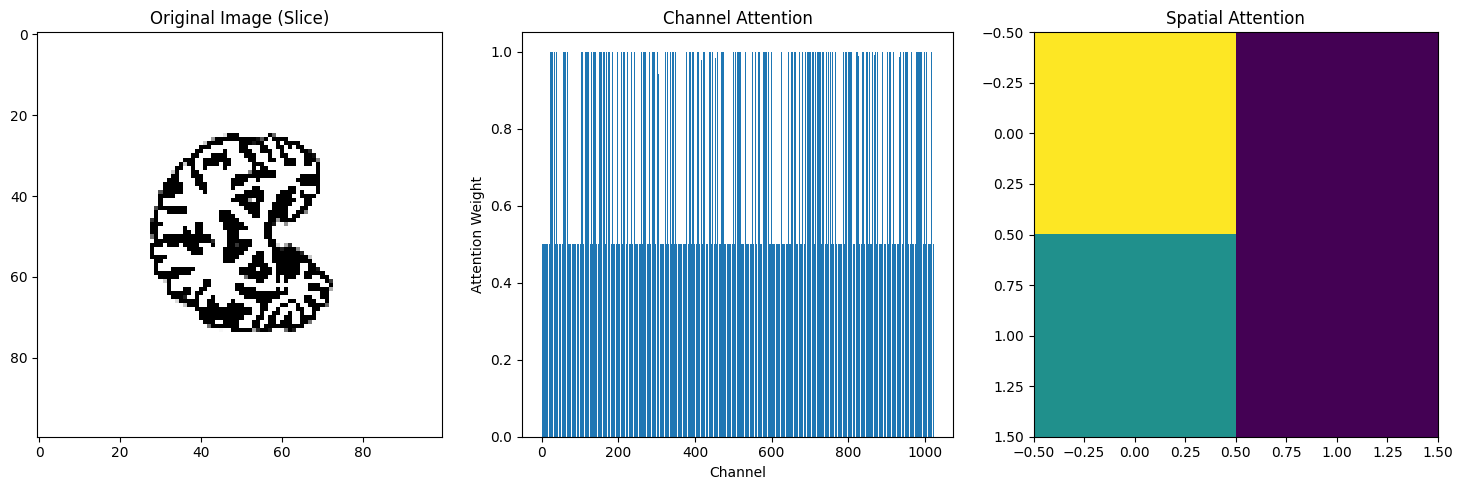

Predicted class: 0
True class: 1
30/30 [==============================] - 271s 9s/step - loss: 12.6611 - accuracy: 0.0819 - recall_2: 0.0819 - auc_2: 0.0819 - precision_2: 0.0819
Test Accuracy: 0.07407407462596893


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling3D, Conv3D

# Function to find the last convolutional layer
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, Conv3D):
            return layer
    return None



# Get the input and the last convolutional layer
model_input = model.input
last_conv_layer = find_last_conv_layer(model)

if last_conv_layer is None:
    raise ValueError("No convolutional layer found in the model.")

print(f"Last convolutional layer: {last_conv_layer.name}")

# Add a Global Average Pooling layer
x = GlobalAveragePooling3D()(last_conv_layer.output)

# Add a new Dense layer for final classification
predictions = Dense(2, activation='softmax', name='predictions')(x)

# Create a new model
prediction_model = Model(inputs=model_input, outputs=predictions)

# Compile the prediction model
prediction_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision()]
)

# Get a batch of test data
test_batch = next(iter(test_dataset))
test_images, test_labels = test_batch

# Run inference with the full model (for attention maps)
full_outputs = model.predict(test_images)

# Run inference with the prediction model
predictions = prediction_model.predict(test_images)

print("Full model outputs shape:", [o.shape for o in full_outputs])
print("Prediction model output shape:", predictions.shape)
print("Test images shape:", test_images.shape)

# Visualize the original image and attention maps
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(test_images[0, :, :, 50, 0]), cmap='gray')
plt.title("Original Image (Slice)")

# Channel Attention
plt.subplot(1, 3, 2)
channel_attention = full_outputs[1][0]  # Adjust index if necessary
plt.bar(range(channel_attention.shape[-1]), channel_attention.flatten())
plt.title("Channel Attention")
plt.xlabel("Channel")
plt.ylabel("Attention Weight")

# Spatial Attention
plt.subplot(1, 3, 3)
spatial_attention = full_outputs[2][0]  # Adjust index if necessary
plt.imshow(np.mean(spatial_attention, axis=2)[:, :, 0], cmap="viridis")
plt.title("Spatial Attention")

plt.tight_layout()
plt.show()

# Print prediction and true label
print(f"Predicted class: {np.argmax(predictions[0])}")
print(f"True class: {np.argmax(test_labels[0])}")

# Evaluate the model on the entire test set using the prediction model
test_accuracy = prediction_model.evaluate(
    test_dataset,
    steps=len(test_paths) // batch_size,
    verbose=1
)
print("Test Accuracy:", test_accuracy[1])  

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [30]:
model_checkpoint = ModelCheckpoint('With_CBAM_6ROI_OASIS_ADvsCN.h5', monitor='val_accuracy', mode='max', save_best_only=True)
num_epoch = 50
history = model.fit(
    train_dataset,
    epochs=num_epoch,
    steps_per_epoch=len(train_paths) // batch_size,
    validation_data=test_dataset,
    validation_steps=len(test_paths) // batch_size,
    callbacks=[model_checkpoint]
)

Epoch 1/50


ValueError: in user code:

    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4979 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/fahim/miniconda3/envs/fydp-old/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:174 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((None, 2, 2, 2, 1) vs (None, None))


In [28]:
saved_model = tf.keras.models.load_model('With_CBAM_6ROI_OASIS_ADvsCN.h5')
test_accuracy = saved_model.evaluate(
    test_dataset,
    steps=len(test_paths) // batch_size,
    verbose=1
)
print("Test Accuracy:", test_accuracy)

30/30 [==============================] - 271s 9s/step - loss: 0.8003 - accuracy: 0.9867 - recall: 0.9867 - auc: 0.9996 - precision: 0.9867
Test Accuracy: [0.8002739548683167, 0.9866666793823242, 0.9866666793823242, 0.999622106552124, 0.9866666793823242]


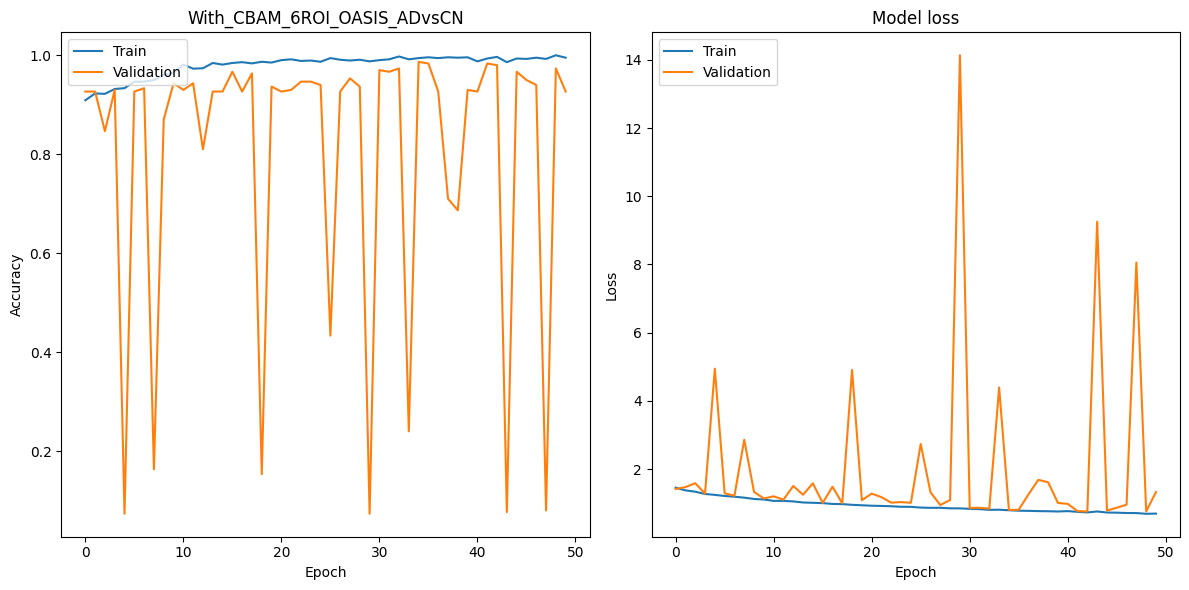

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('With_CBAM_6ROI_OASIS_ADvsCN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("With_CBAM_6ROI_OASIS_ADvsCN.png")

plt.tight_layout()
plt.show()

In [22]:
from tensorflow.keras.models import load_model

model = load_model('With_CBAM_6ROI_OASIS_ADvsCN.h5')

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [25]:

# Load the saved model
saved_model = tf.keras.models.load_model('With_CBAM_6ROI_OASIS_ADvsCN.h5')

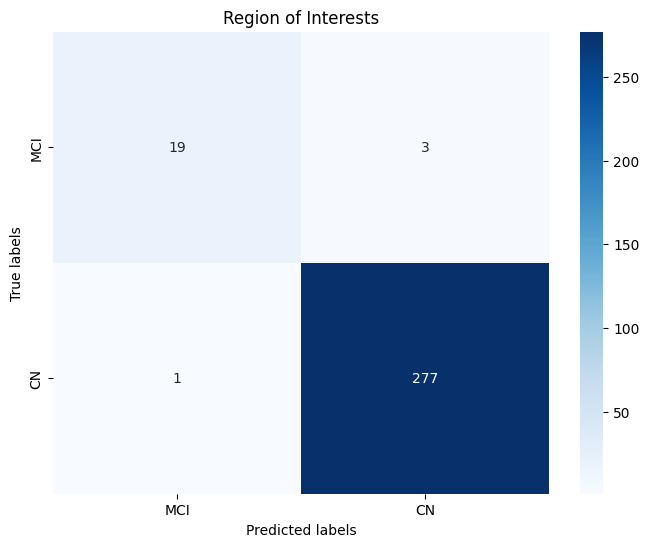

In [26]:

predictions = saved_model.predict(test_dataset, steps=len(test_paths) // batch_size)
predicted_labels = np.argmax(predictions, axis=1)


conf_matrix = confusion_matrix(test_labels[:len(predicted_labels)], predicted_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['MCI', 'CN'], yticklabels=['MCI', 'CN'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Region of Interests')
plt.savefig('confusion_matrix_With_CBAM_6ROI_OASIS_ADvsCN.png')


plt.show()
